In [1]:
#Shree Ganesha

In [66]:
import numpy as np
import datetime
import os
from skimage.io import imread
from keras import backend as K

In [67]:
from skimage.transform import resize as imresize
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
##Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [68]:
import os
np.random.seed(30)

import random as rn
rn.seed(30)

import tensorflow as tf
tf.random.set_seed(30)

In [6]:
train_doc = np.random.permutation(open('/kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/val.csv').readlines())
#setting experimental batch size of 20
batch_size = 20
##Setting image dimension =120x120
xdim, ydim = 120, 120
img_idx_sel = range(0,25,2)

In [7]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize

def generator(source_path, folder_list, batch_size, img_idx_sel, xdim, ydim):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx_sel  # creating a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = ydim, xdim  # note the change in order of ydim and xdim
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # calculate the number of batches based on the total number of folders

        for batch in range(num_batches):  # iterate over the batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # initialize batch data
            batch_labels = np.zeros((batch_size, 5))  # initialize batch labels
            for folder in range(batch_size):  # iterate over the batch
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])  # read all the images in the folder
                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)

                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y, z))  # resize the image

                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels  # yield the batch data and labels


In [13]:
#!ls /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/train


In [14]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/train'
val_path = '/kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20    ### Setting initial 20 epochs to test
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#Input Shape
input_shape = (len(img_idx_sel), xdim, ydim, 3)

In [11]:
### Test Model #1

In [12]:
model = Sequential()
model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Conv3D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [86]:
print ("Model summary : Test #1 ",model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 11, 118, 118,   │         5,248 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 5, 59, 59, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 3, 57, 57, 32)  │        55,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,584,997 (25.12 MB)

 Trainable params: 6,534,821 (24.93 MB)

 Non-trainable params: 50,176 (196.00 KB)

Model summary : Test #1  None


In [87]:
optimiser = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [88]:
train_generator = generator(train_path, train_doc, batch_size,img_idx_sel, xdim, ydim)
val_generator = generator(val_path, val_doc, batch_size,img_idx_sel, xdim, ydim)

In [89]:
# model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

# if not os.path.exists(model_name):
#     os.mkdir(model_name)

# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)   # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]

In [90]:
#####
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

model_name = 'model_init_' + datetime.now().strftime('%Y-%m-%d_%H_%M_%S') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [91]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [94]:
optimiser = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



In [95]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2914 - loss: 18.7137Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 239.13052, saving model to model_init_2024-04-01_17_56_15/model-00001-11.21644-0.32647-239.13052-0.24000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - categorical_accuracy: 0.2924 - loss: 18.4995 - val_categorical_accuracy: 0.2400 - val_loss: 239.1305 - learning_rate: 0.0100
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3302 - loss: 1.4433
Epoch 2: val_loss improved from 239.13052 to 38.14719, saving model to model_init_2024-04-01_17_56_15/model-00002-1.40536-0.38529-38.14719-0.27000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.3318 - loss: 1.4422 - val_categorical_accuracy: 0.2700 - val_loss: 38.1472 - learning_rate: 0.0100
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy

In [107]:
##Checking GPU details
gpu_memory_info = tf.config.experimental.get_memory_info("GPU:0")
gpu_memory_info

{'current': 104691968, 'peak': 1949136128}

In [111]:
""

32


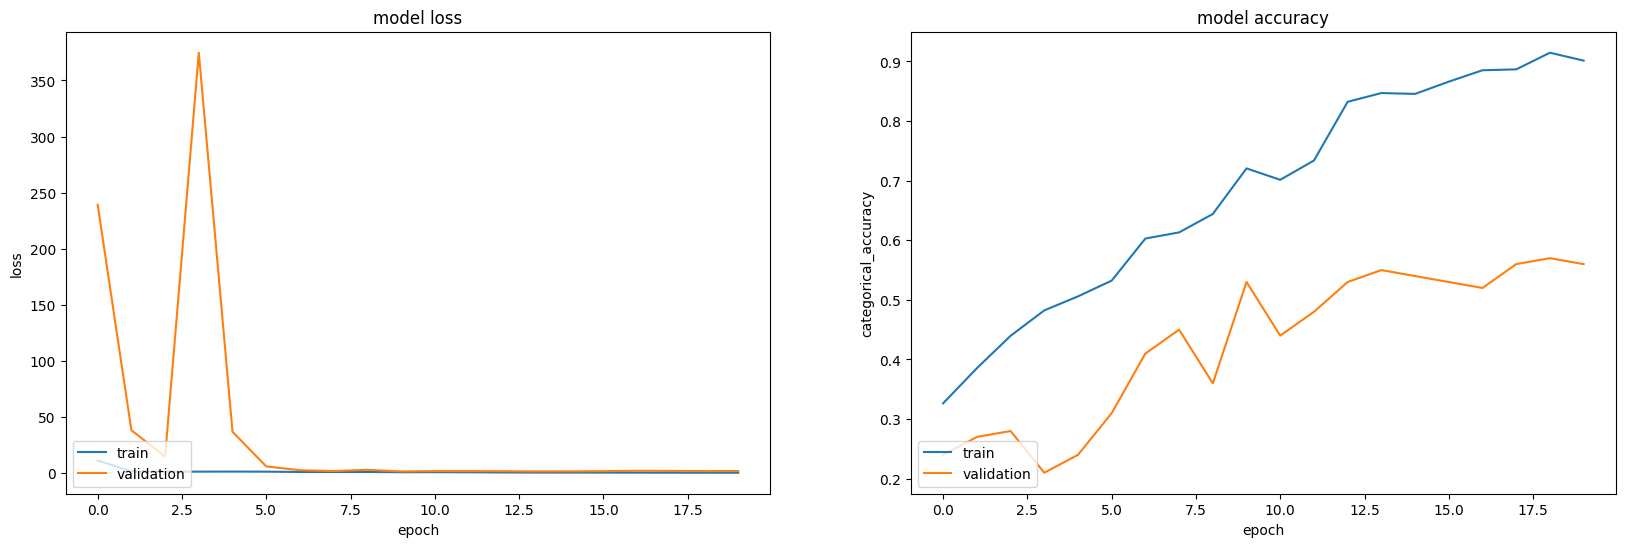

In [97]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [115]:
history

In [116]:
type(history)

keras.src.callbacks.history.History

In [16]:
model2 = Sequential()

model2.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model2.add(Conv3D(64, kernel_size=3, activation='relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, kernel_size=3, activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))

model2.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))

model2.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model2.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(5, activation='softmax'))

In [17]:
optimiser = optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



In [21]:
train_generator = generator(train_path, train_doc, batch_size,img_idx_sel, xdim, ydim)
val_generator = generator(val_path, val_doc, batch_size,img_idx_sel, xdim, ydim)
##can be skipped if ran fully
#####
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_name = 'model_init2_' + datetime.now().strftime('%Y-%m-%d_%H_%M_%S') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model2-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]



In [24]:
print ("Model summary : Test #2 ",model2.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 11, 118, 118,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 9, 116, 116,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 2, 56, 56, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 2, 26, 26, 256) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 2, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 2, 11, 11, 512) │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 2, 9, 9, 512)   │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 2, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,518,353 (143.12 MB)

 Trainable params: 12,506,117 (47.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,012,236 (95.41 MB)

Model summary : Test #2  None


In [22]:
import os
import tensorflow as tf


# Set TensorFlow to use GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU device 0

# Train the model with GPU
history2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1,
                       callbacks=callbacks_list, validation_data=val_generator,
                       validation_steps=validation_steps, class_weight=None,
                       initial_epoch=0, batch_size=batch_size)

Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/train ; batch size = 20
Epoch 1/40


2024-04-02 14:28:54.552924: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,11,118,118]{4,3,2,1,0}, f32[20,64,9,116,116]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-02 14:29:01.261479: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 7.708657308s
Trying algorithm eng0{} for conv (f32[64,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,11,118,118]{4,3,2,1,0}, f32[20,64,9,116,116]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-02 14:29:03.705271:

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1641 - loss: 24148.3027Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.65796, saving model to model_init2_2024-04-02_14_28_27/model2-00001-7746.35742-0.18088-1.65796-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - categorical_accuracy: 0.1646 - loss: 23679.6758 - val_categorical_accuracy: 0.2100 - val_loss: 1.6580 - learning_rate: 0.0100
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2058 - loss: 1.6790
Epoch 2: val_loss improved from 1.65796 to 1.61159, saving model to model_init2_2024-04-02_14_28_27/model2-00002-1.64476-0.20882-1.61159-0.18000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - categorical_accuracy: 0.2059 - loss: 1.6780 - val_categorical_accuracy: 0.1800 - val_loss: 1.6116 - learning_rate: 0.0100
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1828 

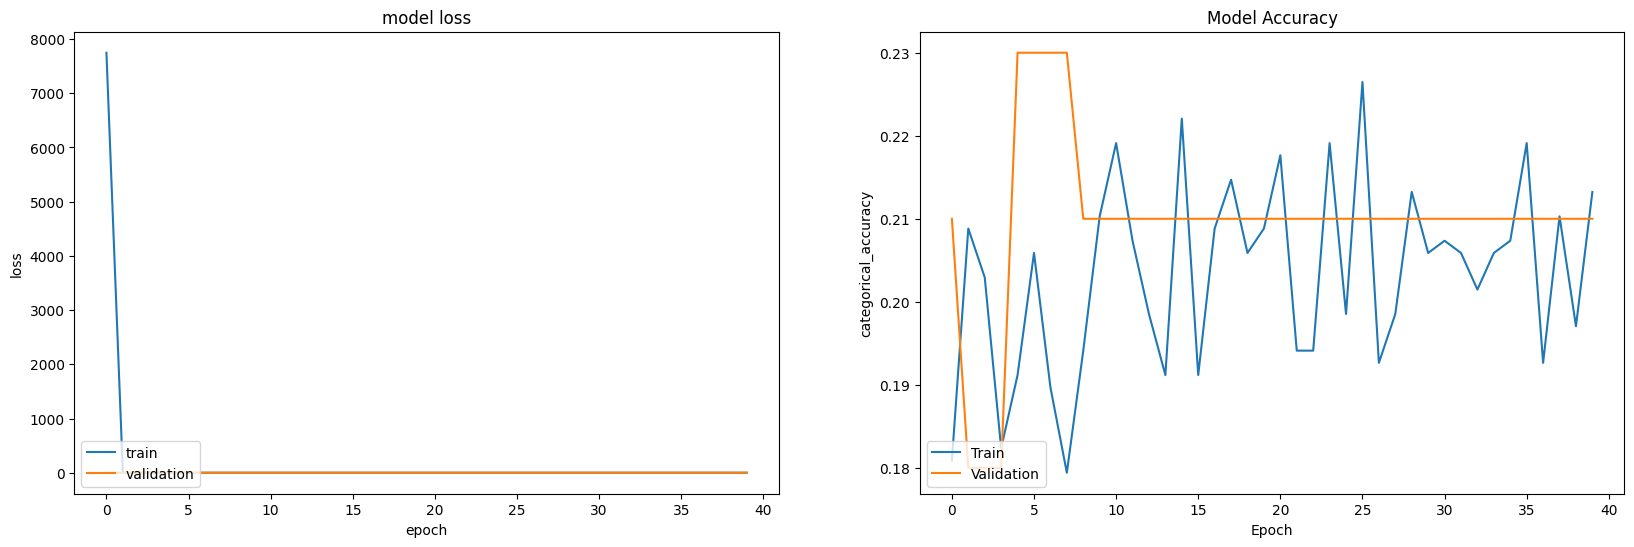

In [25]:
plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)
ax1 = plt.plot(history2.history['loss'])
ax1 = plt.plot(history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

ax2 = plt.subplot(122)
ax2 = plt.plot(history2.history['categorical_accuracy'])
ax2 = plt.plot(history2.history['val_categorical_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

In [26]:
### Model #3

In [27]:
model3 = Sequential()

model3.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))

model3.add(Conv3D(64, kernel_size=3, activation='relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv3D(128, kernel_size=3, activation='relu'))
model3.add(MaxPooling3D(pool_size=(1, 2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model3.add(MaxPooling3D(pool_size=(1, 2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(GlobalAveragePooling3D())
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(5, activation='softmax'))

In [28]:
print ("Model summary : Test #3 ",model3.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 11, 118, 118,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 9, 116, 116,    │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 4, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 58, 58, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 58, 58, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 2, 56, 56, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 2, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 28, 28, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 28, 28, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 2, 26, 26, 256) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 2, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 13, 13, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 13, 13, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 712,453 (2.72 MB)

 Trainable params: 710,533 (2.71 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model summary : Test #2  None


In [29]:
optimiser = optimizers.Adam(learning_rate=0.01)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



In [32]:
train_generator = generator(train_path, train_doc, batch_size,img_idx_sel, xdim, ydim)
val_generator = generator(val_path, val_doc, batch_size,img_idx_sel, xdim, ydim)
##can be skipped if ran fully
#####
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_name = 'model_init3_' + datetime.now().strftime('%Y-%m-%d_%H_%M_%S') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model3-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]



In [31]:
import os
import tensorflow as tf


# Set TensorFlow to use GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU device 0

# Train the model with GPU
history3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1,
                       callbacks=callbacks_list, validation_data=val_generator,
                       validation_steps=validation_steps, class_weight=None,
                       initial_epoch=0, batch_size=batch_size)

Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/train ; batch size = 20
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2444 - loss: 3.3007Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 440.05853, saving model to model_init2_2024-04-02_15_30_00/model2-00001-2.57240-0.28824-440.05853-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - categorical_accuracy: 0.2457 - loss: 3.2799 - val_categorical_accuracy: 0.2300 - val_loss: 440.0585 - learning_rate: 0.0100
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4113 - loss: 1.6918
Epoch 2: val_loss improved from 440.05853 to 85.64986, saving model to model_init2_2024-04-02_15_30_00/model2-00002-1.55547-0.40294-85.64986-0.18000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - categorical_accuracy: 0.4111 - loss: 1.6879 - val_categorical_accuracy: 0.1800 - val_

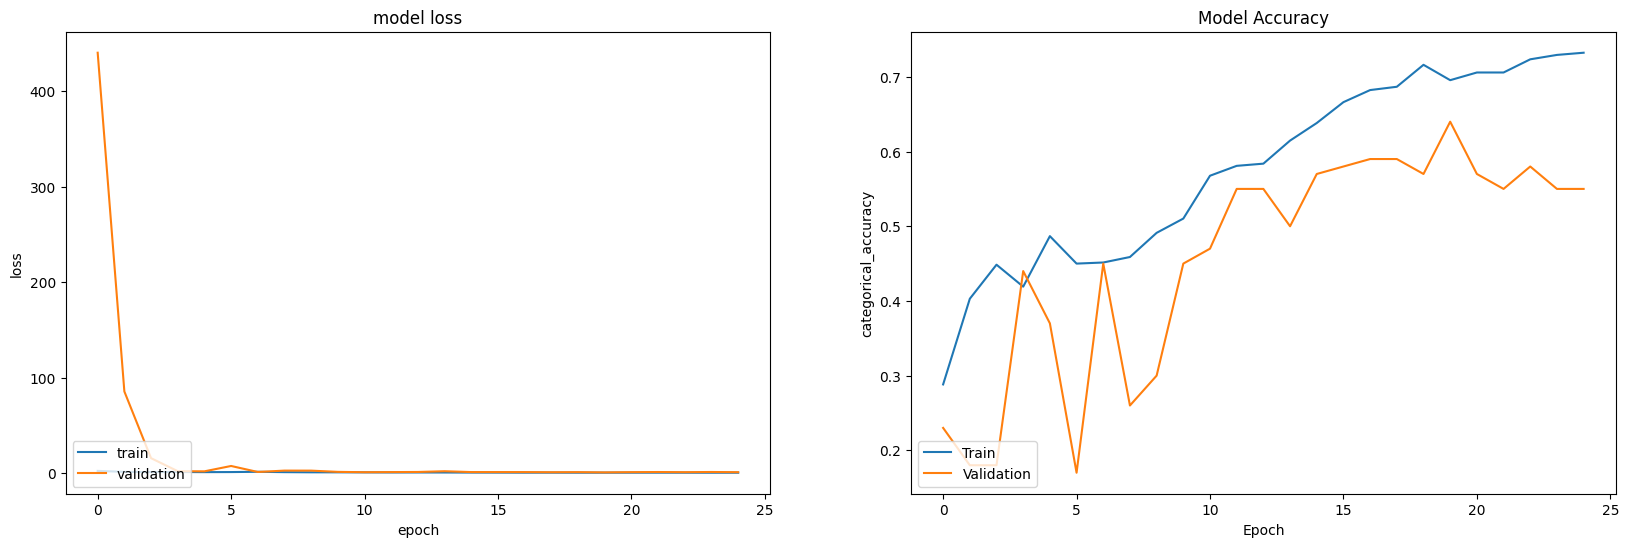

In [34]:
plt.figure(figsize=(20,6))

ax1 = plt.subplot(121)
ax1 = plt.plot(history3.history['loss'])
ax1 = plt.plot(history3.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

ax2 = plt.subplot(122)
ax2 = plt.plot(history3.history['categorical_accuracy'])
ax2 = plt.plot(history3.history['val_categorical_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

In [35]:
# Model #4 with GRU

In [36]:
model4 = Sequential()

#Adding another TimeDistributed MaxPooling2D layer (32)
model4.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model4.add(TimeDistributed(MaxPooling2D((2,2))))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

#Adding another TimeDistributed MaxPooling2D layer (64)
model4.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2,2))))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

#Adding another TimeDistributed GlobalAveragePooling2D layer (64)
model4.add(TimeDistributed(GlobalAveragePooling2D()))
model4.add(TimeDistributed(Dense(64, activation='relu')))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

##Adding GRU Layer (128) with BatchNormalization
model4.add(GRU(128))
model4.add(BatchNormalization())
model4.add(Dense(5, activation='softmax'))

In [46]:
print ("Model summary : Test #4 ",model4.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 13, 118, 118,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 13, 118, 118,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 13, 116, 116,   │         1,168 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 13, 116, 116,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 114, 114, 8)    │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 114, 114, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 114, 114, 64)   │           576 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 114, 114, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,781 (53.83 KB)

 Trainable params: 13,589 (53.08 KB)

 Non-trainable params: 192 (768.00 B)

Model summary : Test #4  None


In [38]:
optimiser = optimizers.Adam(learning_rate=0.01)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [39]:
train_generator = generator(train_path, train_doc, batch_size,img_idx_sel, xdim, ydim)
val_generator = generator(val_path, val_doc, batch_size,img_idx_sel, xdim, ydim)
##can be skipped if ran fully
#####
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_name = 'model_init4_' + datetime.now().strftime('%Y-%m-%d_%H_%M_%S') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model4-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]


In [40]:
import os
import tensorflow as tf


# Set TensorFlow to use GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU device 0

# Train the model with GPU
history4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1,
                       callbacks=callbacks_list, validation_data=val_generator,
                       validation_steps=validation_steps, class_weight=None,
                       initial_epoch=0, batch_size=batch_size)

Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/train ; batch size = 20
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3821 - loss: 1.9277Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 2.53384, saving model to model_init4_2024-04-02_16_15_17/model4-00001-1.66745-0.39559-2.53384-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - categorical_accuracy: 0.3825 - loss: 1.9202 - val_categorical_accuracy: 0.2300 - val_loss: 2.5338 - learning_rate: 0.0100
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4764 - loss: 1.2277
Epoch 2: val_loss did not improve from 2.53384
34/34 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - categorical_accuracy: 0.4768 - loss: 1.2264 - val_categorical_accuracy: 0.2400 - val_loss: 2.7941 - learning_rate: 0.0100
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.50

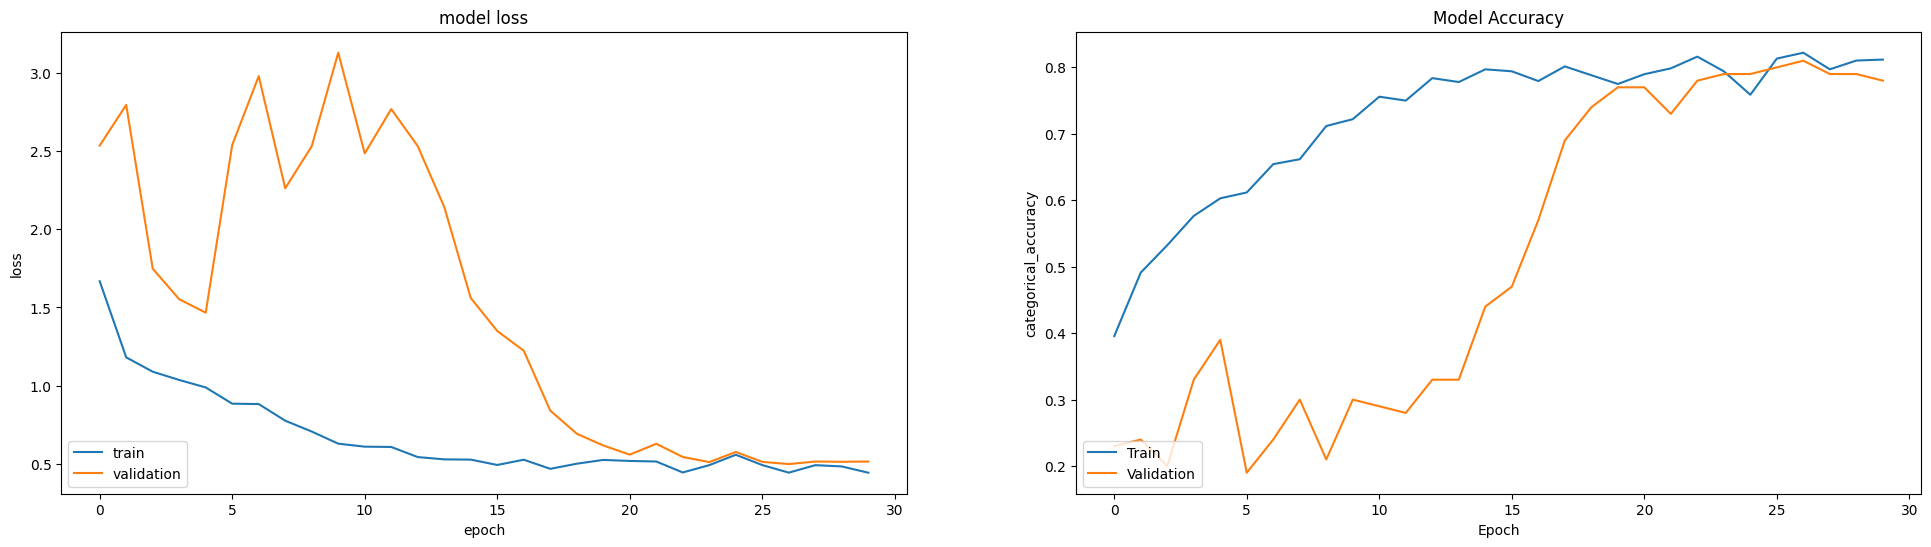

In [43]:
plt.figure(figsize=(24,6))

ax1 = plt.subplot(121)
ax1 = plt.plot(history4.history['loss'])
ax1 = plt.plot(history4.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

ax2 = plt.subplot(122)
ax2 = plt.plot(history4.history['categorical_accuracy'])
ax2 = plt.plot(history4.history['val_categorical_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

In [62]:
print(history4.history.keys())
print(history4.history['loss'][-1])
print(history4.history['categorical_accuracy'][-1])
print(history4.history['val_categorical_accuracy'][-1])
print(history4.history['val_loss'][-1])
print(history4.history['learning_rate'][-1])



dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.44465452432632446
0.8117647171020508
0.7799999713897705
0.5161371827125549
7.812499825377017e-05


In [44]:
# Model #5 with LTSM

In [47]:
model5 = Sequential()

model5.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))

model5.add(BatchNormalization())
model5.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))

model5.add(BatchNormalization())
model5.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))

#Adding BatchNormalization & TimeDistributed relu actived Dense Layer (64)
model5.add(BatchNormalization())
model5.add(TimeDistributed(Dense(64, activation='relu')))

#Adding BatchNormalization & GlobalAveragePooling2D
model5.add(BatchNormalization())
model5.add(GlobalAveragePooling2D())

#Adding Dense Layer - relu (64)
model5.add(Dense(64, activation='relu'))

#Adding Dense Layer - softmax (5)
model5.add(Dense(5, activation='softmax'))

In [48]:
print ("Model summary : Test #5 ",model5.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_9              │ (None, 13, 118, 118,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 13, 118, 118,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 13, 116, 116,   │         1,168 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 13, 116, 116,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 114, 114, 8)    │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 114, 114, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 114, 114, 64)   │           576 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 114, 114, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,781 (53.83 KB)

 Trainable params: 13,589 (53.08 KB)

 Non-trainable params: 192 (768.00 B)

Model summary : Test #5  None


In [49]:
optimiser = optimizers.Adam(learning_rate=0.01)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [50]:
train_generator = generator(train_path, train_doc, batch_size,img_idx_sel, xdim, ydim)
val_generator = generator(val_path, val_doc, batch_size,img_idx_sel, xdim, ydim)
##can be skipped if ran fully
#####
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_name = 'model_init5_' + datetime.now().strftime('%Y-%m-%d_%H_%M_%S') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model5-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]


In [51]:
# Set TensorFlow to use GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU device 0

# Train the model with GPU
history5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1,
                       callbacks=callbacks_list, validation_data=val_generator,
                       validation_steps=validation_steps, class_weight=None,
                       initial_epoch=0, batch_size=batch_size)

Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/train ; batch size = 20
Epoch 1/30


2024-04-02 17:07:40.643207: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 114.175, expected 39.507
2024-04-02 17:07:40.643271: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 112.55, expected 38.7161
2024-04-02 17:07:40.643286: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 111.2, expected 37.8239
2024-04-02 17:07:40.643297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 111.902, expected 38.695
2024-04-02 17:07:40.643309: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 119.327, expected 41.0701
2024-04-02 17:07:40.643321: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 116.819, expected 40.0847
2024-04-02 17:07:40.643332: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 112.531, expected 39.0126
2024-04-02 17:07:40.643344: E external/local_xla/xla/service

 1/34 ━━━━━━━━━━━━━━━━━━━━ 15:49 29s/step - categorical_accuracy: 0.2000 - loss: 1.6249

W0000 00:00:1712077673.782777      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2577 - loss: 1.5804Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 2.48933, saving model to model_init5_2024-04-02_17_06_30/model5-00001-1.53779-0.29559-2.48933-0.18000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - categorical_accuracy: 0.2588 - loss: 1.5792 - val_categorical_accuracy: 0.1800 - val_loss: 2.4893 - learning_rate: 0.0100
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3750 - loss: 1.4020
Epoch 2: val_loss improved from 2.48933 to 1.83630, saving model to model_init5_2024-04-02_17_06_30/model5-00002-1.45668-0.34412-1.83630-0.22000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - categorical_accuracy: 0.3741 - loss: 1.4035 - val_categorical_accuracy: 0.2200 - val_loss: 1.8363 - learning_rate: 0.0100
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3786 - loss: 1.4

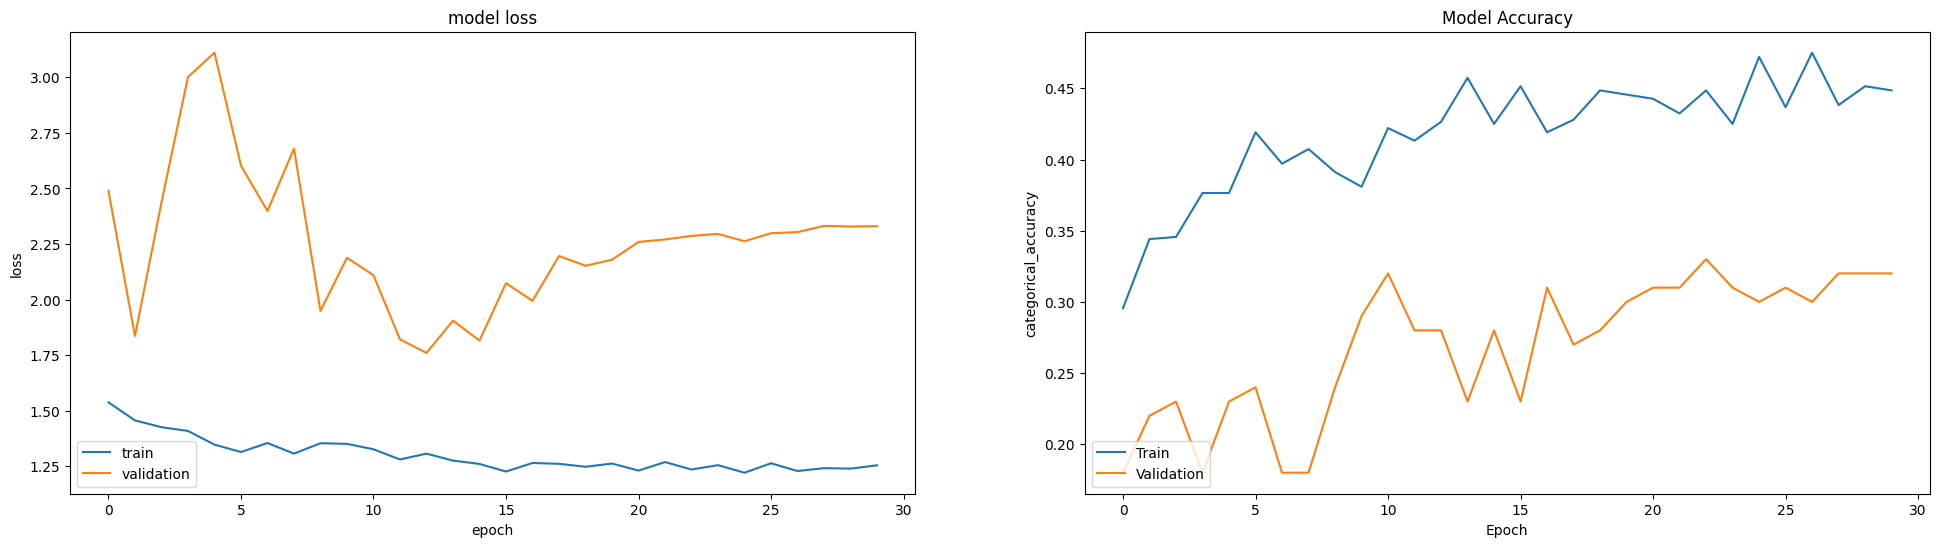

In [52]:
plt.figure(figsize=(24,6))

ax1 = plt.subplot(121)
ax1 = plt.plot(history5.history['loss'])
ax1 = plt.plot(history5.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

ax2 = plt.subplot(122)
ax2 = plt.plot(history5.history['categorical_accuracy'])
ax2 = plt.plot(history5.history['val_categorical_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

In [64]:
#### The best model is Model #4 for the below 2 reasons :
    ### i) The difference between Training & Validation loss is the least
    ### ii) Model accuracy is the best out of all other models

In [69]:
###Re-training model #4 / best model with tunned parameters to see if there is any performance improvement or not.

In [70]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, TimeDistributed, GlobalAveragePooling2D, Dense, GRU

best_model = Sequential()

# Adding a TimeDistributed Convolutional layer with 64filters
best_model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu'), input_shape=input_shape))
# Adding a TimeDistributed MaxPooling2D layer
best_model.add(TimeDistributed(MaxPooling2D((2, 2))))
best_model.add(BatchNormalization())
best_model.add(Dropout(0.25))

# Adding another TimeDistributed Convolutional layer with 128filters
best_model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
# Adding another TimeDistributed MaxPooling2D layer
best_model.add(TimeDistributed(MaxPooling2D((2, 2))))
best_model.add(BatchNormalization())
best_model.add(Dropout(0.25))


# Adding a TimeDistributed GlobalAveragePooling2D
best_model.add(TimeDistributed(GlobalAveragePooling2D()))
best_model.add(TimeDistributed(Dense(128, activation='relu')))
best_model.add(BatchNormalization())
best_model.add(Dropout(0.25))



# Adding a GRU layer with 256 units
best_model.add(GRU(256))
best_model.add(BatchNormalization())
best_model.add(Dense(5, activation='softmax'))

In [71]:
optimiser = optimizers.Adam(learning_rate=0.01)
best_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [72]:
train_generator = generator(train_path, train_doc, batch_size,img_idx_sel, xdim, ydim)
val_generator = generator(val_path, val_doc, batch_size,img_idx_sel, xdim, ydim)
##can be skipped if ran fully
#####
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_name = 'best_model' + datetime.now().strftime('%Y-%m-%d_%H_%M_%S') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'best_model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]


In [73]:
# Set TensorFlow to use GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU device 0

# Train the model with GPU
best_model_history = best_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=35, verbose=1,
                       callbacks=callbacks_list, validation_data=val_generator,
                       validation_steps=validation_steps, class_weight=None,
                       initial_epoch=0, batch_size=batch_size)

Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/train ; batch size = 20
Epoch 1/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3002 - loss: 2.7089Source path =  /kaggle/input/upgrad-gesture-recognistion/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 3.43411, saving model to best_model2024-04-02_18_06_39/best_model-00001-2.08060-0.32059-3.43411-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - categorical_accuracy: 0.3008 - loss: 2.6909 - val_categorical_accuracy: 0.2300 - val_loss: 3.4341 - learning_rate: 0.0100
Epoch 2/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3349 - loss: 1.5444
Epoch 2: val_loss improved from 3.43411 to 3.13097, saving model to best_model2024-04-02_18_06_39/best_model-00002-1.49160-0.36765-3.13097-0.24000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - categorical_accuracy: 0.3358 - loss: 1.5429 - val_categorical_accuracy: 0.2400 - val_loss: 

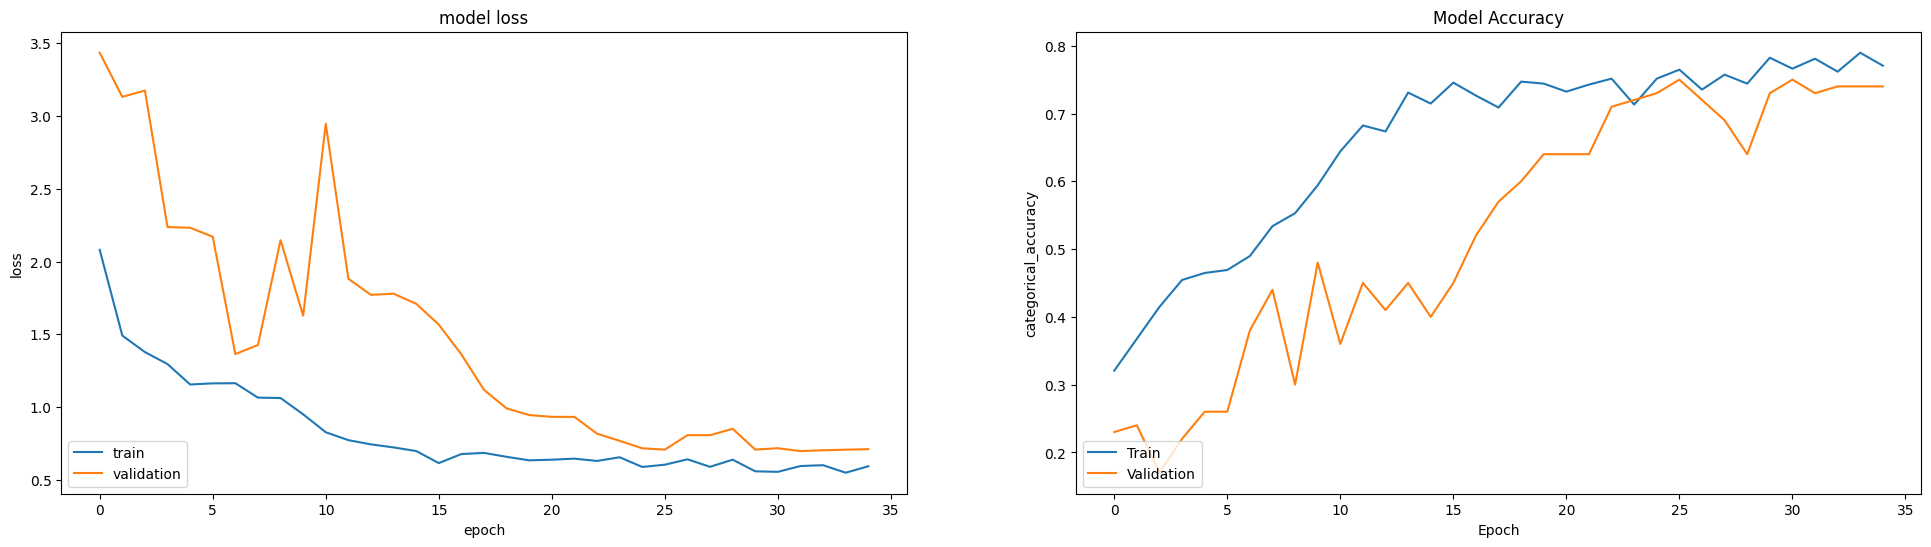

In [74]:
plt.figure(figsize=(24,6))

ax1 = plt.subplot(121)
ax1 = plt.plot(best_model_history.history['loss'])
ax1 = plt.plot(best_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

ax2 = plt.subplot(122)
ax2 = plt.plot(best_model_history.history['categorical_accuracy'])
ax2 = plt.plot(best_model_history.history['val_categorical_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

In [77]:
### The tweaked model is having lower accuracy than model4

In [75]:
print(history4.history.keys())
print(history4.history['loss'][-1])
print(history4.history['categorical_accuracy'][-1])
print(history4.history['val_categorical_accuracy'][-1])
print(history4.history['val_loss'][-1])
print(history4.history['learning_rate'][-1])



dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.44465452432632446
0.8117647171020508
0.7799999713897705
0.5161371827125549
7.812499825377017e-05


In [76]:
print(best_model_history.history.keys())
print(best_model_history.history['loss'][-1])
print(best_model_history.history['categorical_accuracy'][-1])
print(best_model_history.history['val_categorical_accuracy'][-1])
print(best_model_history.history['val_loss'][-1])
print(best_model_history.history['learning_rate'][-1])


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])
0.5940073132514954
0.770588219165802
0.7400000095367432
0.7115480303764343
7.812499825377017e-05


## Please use model4 for test result validation as the tweaked model(best_model) is having marginally lesser accuracy than model4

# Thank you 